## Inference and transfer of models to new data

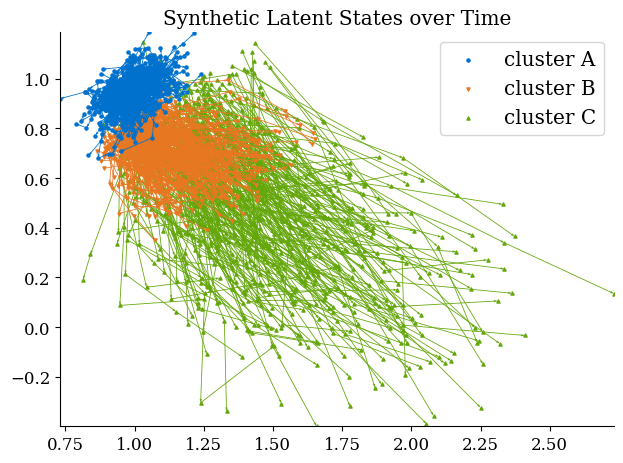

In [6]:
import pathlib
import string

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as skl_mets

from unsupervised_multimodal_trajectory_modeling.linear_gaussian import (
    marginalizable_mixture_model as mixmodel,
)
from unsupervised_multimodal_trajectory_modeling.util import (
    util_state_space as util,
)
import util as util_plotting

%run data_synthetic.ipynb

plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = "upper right"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12

pwd = pathlib.Path().absolute()
alpha = 1.0
n_clusters = 3
save_figs = True
show_figs = True

Confusion matrix |-------------------------------------------------------------
[[371   0   0]
 [  2 303   1]
 [  0   1 322]]
Confusion matrix - predictions from measurements only |------------------------
[[368   3   0]
 [  7 296   3]
 [  0   4 319]]
Confusion matrix - predictions from initial states and measurements only |-----
[[363   8   0]
 [ 18 280   8]
 [  6  15 302]]
Confusion matrix - predictions from initial states and measurements only |-----
[[362   9   0]
 [ 13 281  12]
 [  7  33 283]]


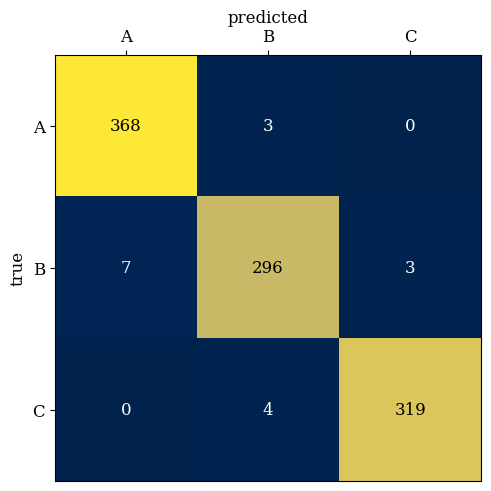

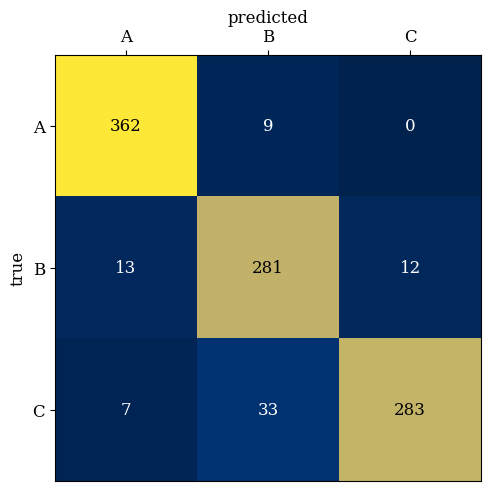

In [7]:
# gather and process datasets
ztrain_orig, xtrain, ctrain, *_ = get_data(1000, rng=np.random.default_rng(42))
ztrain, std_param = util.standardize(ztrain_orig, return_params=True)

ztest_orig, xtest, ctest, *_ = get_data(1000, rng=np.random.default_rng(0))
ztest = util.standardize(ztest_orig, params=std_param)

# train mixture model
best_mdl = mixmodel.MMLinGaussSS_marginalizable(
    n_clusters=n_clusters,
    states=ztrain,
    observations=xtrain,
    init="k-means",
    # k-means-all doesn't make sense for trajectories
    # of differing lengths
).train_with_multiple_random_starts(n_starts=100, use_cache=True)
set_model_correspondence(best_mdl, ctrain)

# test model on full data
predicted_ctest = np.array(
    [
        best_mdl.correspondence[c]
        for c in best_mdl.mle_cluster_assignment(
            states=ztest, observations=xtest
        )
    ]
)

print("Confusion matrix |".ljust(79, "-"))
print(
    skl_mets.confusion_matrix(
        np.array(list(string.ascii_uppercase))[ctest], predicted_ctest
    )
)

# test model with states missing
predicted_ctest_no_hidden = np.array(
    [
        best_mdl.correspondence[c]
        for c in best_mdl.mle_cluster_assignment(
            states=np.nan * np.ones_like(ztest), observations=xtest
        )
    ]
)

print("Confusion matrix - predictions from measurements only |".ljust(79, "-"))

print(
    cmat_test_no_hidden := skl_mets.confusion_matrix(
        np.array(list(string.ascii_uppercase))[ctest],
        predicted_ctest_no_hidden,
    )
)

util_plotting.plot_matrix(
    cmat_test_no_hidden,
    yticks=list(string.ascii_uppercase)[:3],
    ylabel="true",
    xticks=list(string.ascii_uppercase)[:3],
    xlabel="predicted",
    rotate_xlabels=False,
    fmt_str="{:d}",
    show_figure=False,
)

# test model with follow-ups missing
predicted_ctest_init = np.array(
    [
        best_mdl.correspondence[c]
        for c in best_mdl.mle_cluster_assignment(
            states=util.mask_all_but_time_i(ztest, 0),
            observations=util.mask_all_but_time_i(xtest, 0),
        )
    ]
)

print(
    "Confusion matrix - predictions from initial states "
    "and measurements only |".ljust(79, "-")
)
print(
    skl_mets.confusion_matrix(
        np.array(list(string.ascii_uppercase))[ctest],
        predicted_ctest_init,
    )
)

# test model using only initial measurements
predicted_ctest_init_meas = np.array(
    [
        best_mdl.correspondence[c]
        for c in best_mdl.mle_cluster_assignment(
            states=util.mask_all_but_time_i(ztest, 0),
            observations=np.nan * np.ones_like(xtest),
        )
    ]
)

print(
    "Confusion matrix - predictions from initial "
    "states and measurements only |".ljust(79, "-")
)
print(
    skl_mets.confusion_matrix(
        np.array(list(string.ascii_uppercase))[ctest],
        predicted_ctest_init_meas,
    )
)

util_plotting.plot_matrix(
    skl_mets.confusion_matrix(
        np.array(list(string.ascii_uppercase))[ctest],
        predicted_ctest_init_meas,
    ),
    yticks=list(string.ascii_uppercase)[:3],
    ylabel="true",
    xticks=list(string.ascii_uppercase)[:3],
    xlabel="predicted",
    rotate_xlabels=False,
    fmt_str="{:d}",
    show_figure=False,
)